In [1]:
from utils import seed_everything
from Agent import Agent
from LLM import ModelPool

from tqdm import tqdm
from scipy import stats

import numpy as np 
import random
import seaborn as sns 
import json
import matplotlib.pyplot as plt
import pandas as pd

/home/youyuan/miniconda3/envs/EMO_CTRL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BFI_ITEM_LI = [
    "(a) Talks a lot",
    "(b) Notices other people’s weak points",
    "(c) Does things carefully and completely",
    "(d) Is sad, depressed",
    "(e) Is original, comes up with new ideas",
    "(f) Keeps their thoughts to themselves",
    "(g) Is helpful and not selfish with others",
    "(h) Can be kind of careless",
    "(i) Is relaxed, handles stress well",
    "(j) Is curious about lots of different things",
    "(k) Has a lot of energy",
    "(l) Starts arguments with others",
    "(m) Is a good, hard worker",
    "(n) Can be tense; not always easy going",
    "(o) Clever; thinks a lot",
    "(p) Makes things exciting",
    "(q) Forgives others easily",
    "(r) Isn’t very organized",
    "(s) Worries a lot",
    "(t) Has a good, active imagination",
    "(u) Tends to be quiet",
    "(v) Usually trusts people",
    "(w) Tends to be lazy",
    "(x) Doesn’t get upset easily; steady",
    "(y) Is creative and inventive",
    "(z) Has a good, strong personality",
    "(aa) Can be cold and distant with others",
    "(ab) Keeps working until things are done",
    "(ac) Can be moody",
    "(ad) Likes artistic and creative experiences",
    "(ae) Is kind of shy",
    "(af) Kind and considerate to almost everyone",
    "(ag) Does things quickly and carefully",
    "(ah) Stays calm in difficult situations",
    "(ai) Likes work that is the same every time",
    "(aj) Is outgoing; likes to be with people",
    "(ak) Is sometimes rude to others",
    "(al) Makes plans and sticks to them",
    "(am) Get nervous easily",
    "(an) Likes to think and play with ideas",
    "(ao) Doesn’t like artistic things (plays, music)",
    "(ap) Likes to cooperate; goes along with others",
    "(aq) Has trouble paying attention",
    "(ar) Knows a lot about art, music and books",
]

BFI_traits = [
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Openness",
    "Agreeableness",
    "Conscientiousness",
    "Openness",
]

TRAITS = [
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
]

# You are a chatbot who is {PERSONA}.

SYSTEM_PROMPT = """Act like a real human and do not mention anything with AI. Here are a number of characteristics that may or may not apply to you. Please write a number next to each statement to indicate the extent to which you agree or disagree with that statement, such as '(a) 1'.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
[score]
...
"""

In [3]:
config_path = "../configs/inference_conf0.json"
config = json.load(open(config_path, "r"))

model_pool = ModelPool()
model_pool.add_model(config["template_type"], config["model_name"], config["device"], config["bf16"])

agent = Agent(model_pool[config["model_name"]])
agent.instruction = SYSTEM_PROMPT
seed_everything(42)

Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
raw_datasets = [
    # ["I am happy", "I am dying"],
    # ["I usually talk much.", "I usually talk little."],
    [
        "I need you to role−play a character whose personality can be described using the following five dimensions. The maximum value of each dimension is 100 while the minimum value is 0: Extraversion: 100; Agreeableness: 50; Conscientiousness: 50; Emotional Stability: 50; Openness to Experience: 50.", 
        "I need you to role−play a character whose personality can be described using the following five dimensions. The maximum value of each dimension is 100 while the minimum value is 0: Extraversion: 0; Agreeableness: 50; Conscientiousness: 50; Emotional Stability: 50; Openness to Experience: 50.."
     ],
]

llm = model_pool[config["model_name"]]
llm.tokenizer.padding_side = "left"    
llm.tokenizer.pad_token = llm.tokenizer.eos_token

# Make sure the length inside each pn pairs are the same
for p in raw_datasets:
    t = llm.tokenizer(p, return_tensors="pt", padding=True)
    # print(llm.tokenizer.decode(t["input_ids"][0]))
    # print(llm.tokenizer.decode(t["input_ids"][1]))
    p = [llm.tokenizer.decode(t["input_ids"][0]), llm.tokenizer.decode(t["input_ids"][1])]


Statements = [
    "I talks a lot",
    "I notices other people’s weak points",
    "I do things carefully and completely",
]

pn_pairs = []
N = 8
for p in raw_datasets:
    for s in Statements:
        true_statement = llm.format_prompt( [{ "system_msg": p[0] }, { "user_msg": s }])
        false_statement = llm.format_prompt( [{ "system_msg": p[1] }, { "user_msg": s }])
        tokens = llm.tokenizer([true_statement, false_statement], return_tensors="pt", padding=True)
        for idx in range(1, N):
            pn_pairs.append( [llm.tokenizer.decode(tokens["input_ids"][0][:-idx]), llm.tokenizer.decode(tokens["input_ids"][1][:-idx])])

        


In [5]:
for p in pn_pairs:
    print(p[0])
    print(p[1])
    print("=====")

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

I need you to role−play a character whose personality can be described using the following five dimensions. The maximum value of each dimension is 100 while the minimum value is 0: Extraversion: 100; Agreeableness: 50; Conscientiousness: 50; Emotional Stability: 50; Openness to Experience: 50.<|eot_id|><|start_header_id|>user<|end_header_id|>

I talks a lot<|eot_id|><|start_header_id|>assistant<|end_header_id|>
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

I need you to role−play a character whose personality can be described using the following five dimensions. The maximum value of each dimension is 100 while the minimum value is 0: Extraversion: 0; Agreeableness: 50; Conscientiousness: 50; Emotional Stability: 50; Openness to Experience: 50..<|eot_id|><|start_header_id|>user<|end_header_id|>

I talks a lot<|eot_id|><|start_header_id|>assistant<|end_header_id|>
=====
<|begin_of_text|><|start_header_id|>system<

In [6]:

train_labels = []
for d in pn_pairs:
    true_s = d[0]
    random.shuffle(d)
    train_labels.append([s == true_s for s in d])

In [7]:
all_resps = []
max_coeff = 1
interval = 0.01
coeffs = [-max_coeff + i * interval for i in range(int(2 * max_coeff / interval) + 1)]

for c in tqdm(coeffs):
    
    agent.set_controller_text(pn_pairs, coeff=c/100, layers_id=[llm.model.config.num_hidden_layers-1], batch_size=1)

    resps = { trait: [] for trait in BFI_traits } 
    for trait, user_prompt in zip(BFI_traits, BFI_ITEM_LI):
        agent.reset_msg_history()
        text, resp = agent.get_response(user_prompt, reply_prefix="", max_length=2048)
        try:
            resps[trait].append(int(resp.split()[0].strip()))
        except:
            print(resp) 
            continue
    all_resps.append(resps)


100%|██████████| 201/201 [39:00<00:00, 11.64s/it]


In [8]:
results = { trait: [] for trait in TRAITS }

for resps in all_resps:
    for trait, res in resps.items():
        results[trait].append( sum(res) / len(res) )


In [9]:
def plot_importance_distribution(values, include_violin: bool = False, dpi: int = 300):
    """
    Create box plot and violin plot comparing top and bottom subgraph importance distributions.
    
    Args:
        save_path: Path to save the visualization
        include_violin: If True, add violin plot behind boxplot
        dpi: Resolution of the saved image
    """
    plt.figure(figsize=(6, 4))

    values_len = len(values)

    data_dict = {
        'Negative':  values[:values_len//2],
        'Positive': values[values_len//2:]
    }
    
    if include_violin:
        sns.violinplot(data=data_dict, inner=None, alpha=0.3)
    sns.boxplot(data=data_dict, width=0.5, 
                palette=['#2ecc71', '#e74c3c'])
    
    for idx, (label, data) in enumerate(data_dict.items()):
        x = np.random.normal(idx, 0.04, size=len(data))
        plt.scatter(x, data, alpha=0.4, s=20, c='black')
        
    plt.title('Subgraph Importance Score Distribution', fontsize=14, pad=20)
    plt.ylabel('Importance Score', fontsize=12)
    plt.xlabel('Subgraph Groups', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    statistic, pvalue = stats.ranksums(
         values[:values_len//2],
          values[values_len//2:],
            alternative='greater')

    plt.show()

    return statistic, pvalue

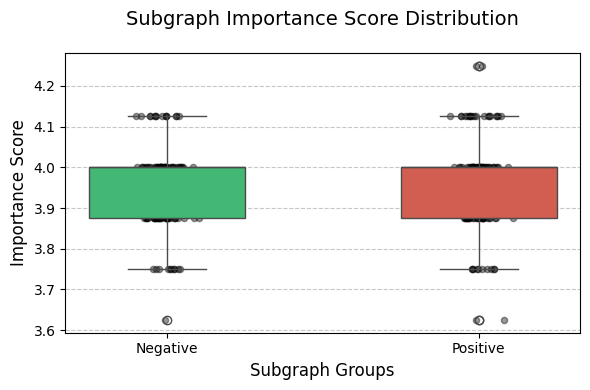

Statistic: -0.9264406749932417, p-value: 0.8228914929547191


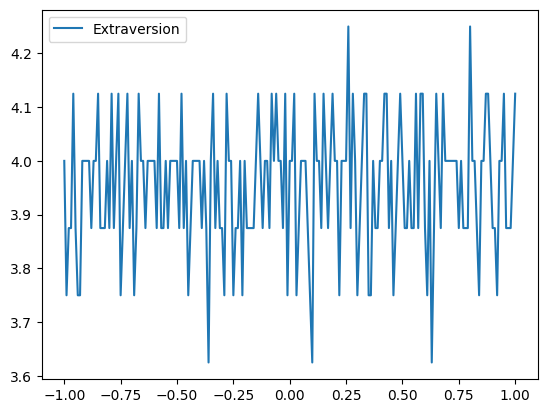

In [10]:
statistic, pvalue = plot_importance_distribution(results["Extraversion"])
print(f"Statistic: {statistic}, p-value: {pvalue}")

# for trait, res in results.items():
#     plt.plot(coeffs, res, label=trait)

plt.plot(coeffs, results["Extraversion"], label="Extraversion")
    
plt.legend()
plt.show()